# Exercise 6
The data used in this notebook can be (re)generated in the following way:
- Adjust the first line of the Makefile to use your c++20 capable compiler
- Run ```make clean``` to remove any artefacts of previous builds or runs
- Generate the executable ```main``` using the Makefile by issuing ```make all```
- Run the executable by issuing ```./main```
- Once the executable returns, you should have the files temps_train.txt, spins_train.txt, temps_verify.txt and spins_verify.txt

In [1]:
print("Appending to path")
import os
os.add_dll_directory("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin")
os.add_dll_directory("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\libnvvp")
os.add_dll_directory("C:\\tools\\cuda\\bin")
print("Importing tensorflow")
import tensorflow as tf

print("Importing keras")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

Appending to path
Importing tensorflow
Importing keras


In [2]:
#Device Name
print("Device Name: "+tf.test.gpu_device_name())
# Version-check
print("Version: "+tf.__version__)
#CUDA Support
print("CUDA Support: "+str(tf.test.is_built_with_cuda()))

Device Name: /device:GPU:0
Version: 2.8.0
CUDA Support: True


Here we define a helper function that allows us to visualize spin configurations

In [7]:
def plot_configuration(spins):
    '''
    
    this is just a helper function to plot the configuration of spins  given by 'spins'
    
    '''
    N = np.shape(spins)[1]
    fig, ax = plt.subplots()
    #fig.add_axes()
    ax = fig.axes[0]
    for i in range(N):
        ax.plot([i, i], [0,N-1], 'k')
        ax.plot([0,N-1], [i,i], 'k')

    colors = ['b', 'gold'] # note: blue is down, gold is up!
    for i in range(N):
        for j in range(N):
            fig.gca().add_patch(plt.Circle((i,j), radius=0.35, fc=colors[int((spins[i,j]+1)/2.)]))
   
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.axis('off')
    plt.savefig('ising.png')
    fig.show()

## Loading the data
As a first step, we need to load the data. We then choose one configuration and visualize it, as a sanity check that everything went well.

In [4]:
#Load configurations data
N=32
configs = np.loadtxt("spins_train.txt")
labels = np.loadtxt("temps_train.txt")
print("loaded %i training configurations of size %ix%i for training"%(len(configs), N,N))

loaded 20000 training configurations of size 32x32 for training


In [5]:
test_x = np.array(np.loadtxt("spins_verify.txt"))
test_label = np.array(np.loadtxt("temps_verify.txt"))
print("loaded %i test configurations of size %ix%i for prediction"%(len(test_x), N,N))

loaded 100000 test configurations of size 32x32 for prediction


C:\Users\Pascal\AppData\Local\Temp/ipykernel_17512/1646538860.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


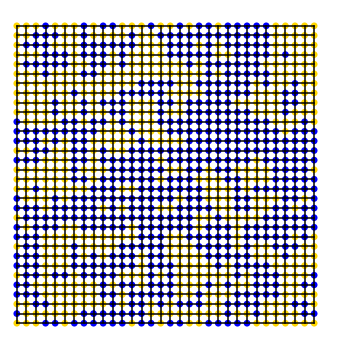

In [8]:
plot_configuration(np.reshape(np.array(test_x[75420]), (N,N)))

## Preprocessing the data
Before we can use this data to train a neural network, we need to perform some preprocessing. The output layer of the network will consist of two nodes, and we want to have the state (1,0) denote the low temperature phase, and (0,1) the high temperature phase. Thus we need to generate those labels from the temperature data, for each sample. Note that we don't use samples that are close to the critical point.

In [9]:
#Prepare data for training
#Exclude temperatures close to transition
T_low = 2.1
T_high = 2.4
x = []
y = []
for i, label in enumerate(labels):
    if label < T_low:
        x.append(configs[i])
        y.append((1,0))
    if label > T_high:
        x.append(configs[i])
        y.append((0, 1))
x = np.array(x)
y = np.array(y)

## Constructing and training the network
Now we construct a neural net, as described on the exercise sheet (and the link mentioned in there). We then compile and train it with our training data.

In [10]:
#Construct the network
model=Sequential()
model.add(Dense(100,input_dim=N*N,activation='sigmoid',kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01))) #Hidden layer
model.add(Dense(2,activation='softmax',kernel_initializer='random_normal')) #Output layer

In [11]:
#Compile the network
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
#Train the network
a=model.fit(x,y,epochs=100,batch_size=32,validation_split=0.1)

Epoch 1/100
563/563 [==============================] - 2s 2ms/step - loss: 0.2356 - accuracy: 0.9954 - val_loss: 4.8318 - val_accuracy: 0.4160
Epoch 2/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0112 - accuracy: 0.9998 - val_loss: 6.6704 - val_accuracy: 0.4160
Epoch 3/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0095 - accuracy: 0.9998 - val_loss: 8.1023 - val_accuracy: 0.4165
Epoch 4/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0257 - accuracy: 0.9986 - val_loss: 5.8650 - val_accuracy: 0.4165
Epoch 5/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 9.1898 - val_accuracy: 0.4160
Epoch 6/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 10.6747 - val_accuracy: 0.4160
Epoch 7/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0320 - accuracy: 0.9981 - val_loss: 5.4242 - val_accuracy: 0.471

Epoch 58/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 12.0381 - val_accuracy: 0.4160
Epoch 59/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 12.7619 - val_accuracy: 0.4160
Epoch 60/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 13.5896 - val_accuracy: 0.4160
Epoch 61/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 14.4707 - val_accuracy: 0.4160
Epoch 62/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0655 - accuracy: 0.9966 - val_loss: 11.0701 - val_accuracy: 0.4165
Epoch 63/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 11.7836 - val_accuracy: 0.4160
Epoch 64/100
563/563 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 12.3922 - val_ac

## Predictions
Now that the network is trained, we can use it to predict the phase of our verification samples. Note that the network has never seen these samples before. It hasn't even seen samples at most of those temperatures before.

In [13]:
prediction=model.predict(test_x)

We need to decode the output of the network again. For each temperature, we count how often the network predicted which phase to obtain a phase probability. We also calculate the average magnetization at each temperature.

In [14]:
Temps = list(np.sort(list(set(test_label))))
NT = len(Temps)
phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.
for i, T in enumerate(test_label):
    j = Temps.index(T)
    #phase1[j]+=prediction[i:i+1, 0][0]
    #phase2[j]+=prediction[i:i+1, 1][0]
    phase1[j]+=prediction[i][0]
    phase2[j]+=prediction[i][1]
    m[j] += abs(np.mean(test_x[i]))
    points[j]+=1.

for j in range(NT):
    phase1[j] /= points[j]
    phase2[j] /= points[j]
    m[j] /= points[j]


Now we can visualize the results. For each temperature we display the fraction of samples that were predicted to be in either of the two phases, along with the calculated magnetization.

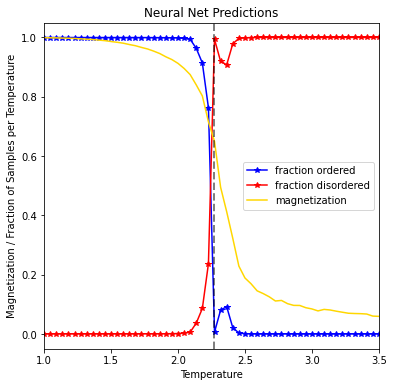

In [15]:
plt.plot(Temps, phase1, 'b', marker='*', label='fraction ordered')
plt.plot(Temps, phase2, 'r', marker='*', label='fraction disordered')
plt.plot(Temps, m, label='magnetization',c='gold')
plt.title("Neural Net Predictions")
plt.legend()
plt.xlim(1,3.5)
plt.axvline(2/np.log(1+np.sqrt(2)),ls='--',lw=2,c='black',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Magnetization / Fraction of Samples per Temperature')
plt.savefig('isingSupervised.pdf')
plt.show()